# Homework 4 -- Omar Godinez

**Due Wednesday, November 30 by midnight**. You may submit this assignment in groups of 2. Be sure to put your names above.

In this homework, we approach the problem of identifying a small subset of a dataset using unsupervised and supervised methods. The dataset we'll use is a set of newsgroup postings from the early days of the internet.

In a real world application, we often don’t have labels, and clustering and outlier detection are usually applied in settings that don’t have labels. For the clustering part of this homework, you should work without the ground truth labels as much as possible. Often inspecting and visualizing the data is the only way to understand the result of clustering.

However, since we do have ground-truth we could do a post-hoc analysis and determine how well we actually did. You  might explore that after you've done the clustering.

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_20newsgroups
newsgroups = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'))

all_df = pd.DataFrame({'Text': newsgroups.data, 'Category Label': newsgroups.target})
all_df['Category Name'] = all_df['Category Label'].map(lambda idx: newsgroups.target_names[idx])
print(all_df['Category Name'].value_counts())
print(all_df['Text'][0])
all_df

rec.sport.hockey            600
soc.religion.christian      599
rec.motorcycles             598
rec.sport.baseball          597
sci.crypt                   595
rec.autos                   594
sci.med                     594
comp.windows.x              593
sci.space                   593
comp.os.ms-windows.misc     591
sci.electronics             591
comp.sys.ibm.pc.hardware    590
misc.forsale                585
comp.graphics               584
comp.sys.mac.hardware       578
talk.politics.mideast       564
talk.politics.guns          546
alt.atheism                 480
talk.politics.misc          465
talk.religion.misc          377
Name: Category Name, dtype: int64
I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme 

,Text,Category Label,Category Name
0,I was wondering if anyone out there could enli...,7,rec.autos
1,A fair number of brave souls who upgraded thei...,4,comp.sys.mac.hardware
2,"well folks, my mac plus finally gave up the gh...",4,comp.sys.mac.hardware
3,\nDo you have Weitek's address/phone number? ...,1,comp.graphics
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space
...,...,...,...
11309,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med
11310,"I have a (very old) Mac 512k and a Mac Plus, b...",4,comp.sys.mac.hardware
11311,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware
11312,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics


# Task 0: Split the Data (2 points)

Choose any 3-6 categories. Create a new dataframe containing only the rows in those categories.

In [3]:
df = all_df.copy()
for index, row in all_df.iterrows():
    if row['Category Label'] not in [5, 14, 16]: #(3, 5, 14, 16)
        df = df.drop(index, axis=0)
df

,Text,Category Label,Category Name
4,"From article <C5owCB.n3p@world.std.com>, by to...",14,sci.space
5,\n\n\n\n\nOf course. The term must be rigidly...,16,talk.politics.guns
13,"\n {Description of ""External Tank"" option fo...",14,sci.space
19,QUESTION:\n What is the EXACT entry (paramete...,5,comp.windows.x
39,/ iftccu:talk.politics.guns / vincent@cad.gate...,16,talk.politics.guns
...,...,...,...
11261,\n\n\nI should probably re-post this with anot...,14,sci.space
11275,\nThis sounds like another of Ali AbuTaha's 57...,14,sci.space
11279,"\nThey aren't functions, they are character ar...",5,comp.windows.x
11286,\n\n\n\n\nThe HGA isn't all that reflective in...,14,sci.space


# Task 1: Vectorization (6 points)

## 1.1 Plain Tfidf

Vectorize the data using TfIdf. Do not change the defaults. What are the top 10 most 'important' (highest tfidf score) words?

In [4]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Text'])
sorted(list(zip(vectorizer.get_feature_names(), X.sum(0).getA1())), #zip attach words with scores, sum all same word scores
       key=lambda x: x[1], reverse=True)[:10]

D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


[('the', 209.31601103016376),
 ('to', 120.56348227005158),
 ('of', 98.82391907835932),
 ('and', 87.58888777266488),
 ('is', 75.49606017609325),
 ('in', 72.56922875896419),
 ('that', 70.66599266193465),
 ('it', 66.27181560453367),
 ('you', 63.04330328270762),
 ('for', 55.60528057605266)]

## 1.2 Better Tfidf

Now vectorize again but this time choose reasonable values for some of the parameters, such as stop_words. What are the top 10 most 'important' terms now?

In [5]:
my_SWords = ENGLISH_STOP_WORDS.union(['just', 'don'])
vectorizer2 = TfidfVectorizer(max_features=100, stop_words = my_SWords, norm='l2')
X2 = vectorizer2.fit_transform(df['Text'])
X3 =sorted(list(zip(vectorizer2.get_feature_names(), X2.sum(0).getA1())), #zip attach words with scores, sum all same word scores
      key=lambda x: x[1], reverse=True)
X3[:10]

[('like', 102.34763968899165),
 ('space', 95.5057956566475),
 ('people', 88.36555263792181),
 ('know', 84.35654504315336),
 ('use', 80.48864654446753),
 ('think', 76.99868339141366),
 ('gun', 70.12092665599435),
 ('time', 66.86837255252799),
 ('does', 64.39047359928061),
 ('window', 64.06606725991989)]

# Task 2: Dimensionality Reduction and Visualization (8 points)

## 2.1 PCA

Use PCA to reduce your "Better Tfidf" data to 2 dimensions and plot the data. Color each point by its category. Make sure the plot has a useful legend.

Do you see anything notable?

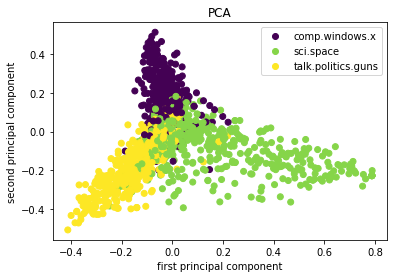

In [6]:
pca = PCA(n_components=2)
x = X2.toarray()
X_pca = pca.fit_transform(x)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['Category Label'])
plt.title("PCA")
#plt.legend(*scatter.legend_elements())
plt.legend(handles=scatter.legend_elements()[0], labels=['comp.windows.x', 'sci.space', 'talk.politics.guns'])
plt.xlabel("first principal component")
plt.ylabel("second principal component");

## 2.2 T-SNE

Now do the same with T-SNE. See if tuning the perplexity parameter helps obtaining a better visualization.

Do you see anything notable?

Note: You may want to re-run Tfidf and set the max_features parameter to some reasonable value (e.g., 100). Otherwise TSNE may take a very long time.

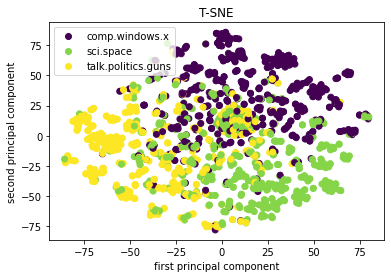

In [7]:
X_tsne = TSNE(perplexity=6, learning_rate='auto', init='random').fit_transform(x)
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['Category Label'])
plt.title("T-SNE")
plt.legend(handles=scatter.legend_elements()[0], labels=['comp.windows.x', 'sci.space', 'talk.politics.guns'])
plt.xlabel("first principal component")
plt.ylabel("second principal component");

## Task 3: Clustering (12 points)

Now we will cluster the Tfidf-vectorized data. (Do NOT cluster on the PCA- or TSNE-reduced data.) For each algorithm, try to manually tune the parameters for a reasonable outcome and document how you tuned the parameters. In particular pay attention to the sizes of the clusters created.

Manually inspect the outcomes as well as you can and identify if any of the resulting clusters are meaningful (as far as you can tell).

### 3.1 KMeans

Use KMeans to cluster the data. Use the PCA or TSNE projections (your choice) to make another scatterplot, but this time color the points by their cluster label from KMeans.

On the same plot, plot the cluster centers that KMeans found. This will mean you'll need to use your fit PCA or TSNE model to transform into 2 dimensions. Plot these with a different marker shape.

For each cluster center, find the 5 closest posts and print them. Do you notice anything useful? Hint: `KMeans` has a transform method that might be useful. Hint 2: `np.argsort` is your friend.

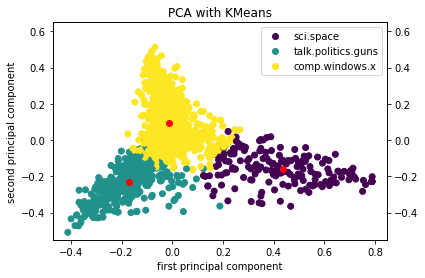

In [8]:
km = KMeans(n_clusters=3, random_state=0)
km.fit(x)
t_pca = pca.transform(km.cluster_centers_)

fig, ax1 = plt.subplots()
plot_1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=km.labels_)
ax1.set_xlabel('first principal component')
ax1.set_ylabel('second principal component')
ax2 = ax1.twinx()
plot_2 = ax2.scatter(t_pca[:, 0], t_pca[:, 1], color ='RED') #plot centers
ax2.set_ylim(-0.55, 0.65)
ax1.set_ylim(-0.55, 0.65)
plt.title("PCA with KMeans")
ax1.legend(handles=plot_1.legend_elements()[0], labels=['sci.space', 'talk.politics.guns', 'comp.windows.x'])
plt.show()

In [13]:
labels=np.array(['sci.space', 'talk.politics.guns', 'comp.windows.x'])
j=0
for c in t_pca:
    cp = np.argsort(np.sum((X_pca - c)**2, axis=1))[:5]
    print(labels[j],"Center:", c)
    j+=1
    print("5 closest points:")
    for i in cp:
        print(X_pca[i])

sci.space Center: [ 0.43603345 -0.16197504]
5 closest points:
[ 0.43754048 -0.17424961]
[ 0.42942589 -0.18108383]
[ 0.4192398  -0.15067001]
[ 0.42294337 -0.18206508]
[ 0.45601957 -0.17746952]
talk.politics.guns Center: [-0.17037443 -0.2309182 ]
5 closest points:
[-0.17135097 -0.22645308]
[-0.17786903 -0.23499313]
[-0.16633413 -0.22227972]
[-0.17316063 -0.24226447]
[-0.18321443 -0.23240366]
comp.windows.x Center: [-0.01157852  0.09503581]
5 closest points:
[-0.01178414  0.09929511]
[-0.01586767  0.09416351]
[-0.01582761  0.09283234]
[-0.00796706  0.09875578]
[-0.01041392  0.10090173]


## 3.2 Agglomerative Clustering

Use Agglomerative Clustering (with ward linkage) to cluster the data. Create a dendrogram for agglomerative clustering (the truncate_mode='level' might be useful).

Manually inspect the outcomes as well as you can and identify if any of the resulting clusters are meaningful (as far as you can tell).

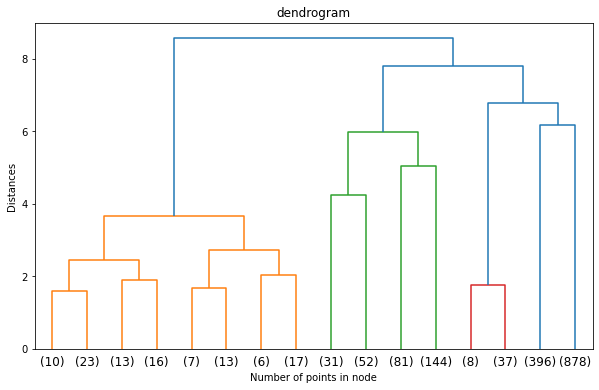

In [14]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(x)

counts = np.zeros(clustering.children_.shape[0])
n_samples = len(clustering.labels_)
for i, merge in enumerate(clustering.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([clustering.children_, clustering.distances_, counts]).astype(float)

plt.figure(figsize=(10, 6))
fig = dendrogram(linkage_matrix, truncate_mode="level", p=3)
plt.title("dendrogram")
plt.xlabel("Number of points in node")
plt.ylabel("Distances")
plt.show()

## 3.3 DBSCAN

Use DBSCAN to cluster the data. Make a scatterplot of the results using the PCA or TSNE transformations. You don't need to worry about plotting the cluster centers in this case.

Manually inspect the outcomes as well as you can and identify if any of the resulting clusters are meaningful (as far as you can tell).

[-1  0  0 ...  0 -1  0]


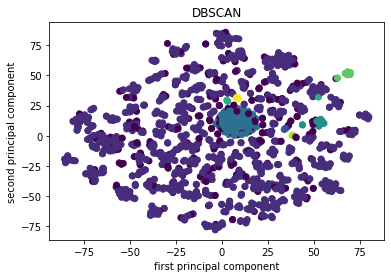

In [15]:
dbscan = DBSCAN(eps=0.9, min_samples=3).fit(X2)
print(dbscan.labels_)
#plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dbscan.labels_)
plt.title("DBSCAN")
plt.xlabel('first principal component')
plt.ylabel('second principal component');

# Task 4: Classification (12 points)

Now it's time to see if we can build a classifier.

## 4.1 Baseline

Pick a linear model and create a simple baseline classifier.

What words/terms does the model think are most important? Try to interpret your model.

In [16]:
lr = LogisticRegression(solver='liblinear').fit(X2, df['Category Label'])
print(f"{lr.score(X2, df['Category Label']):.3f}")

0.850


D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


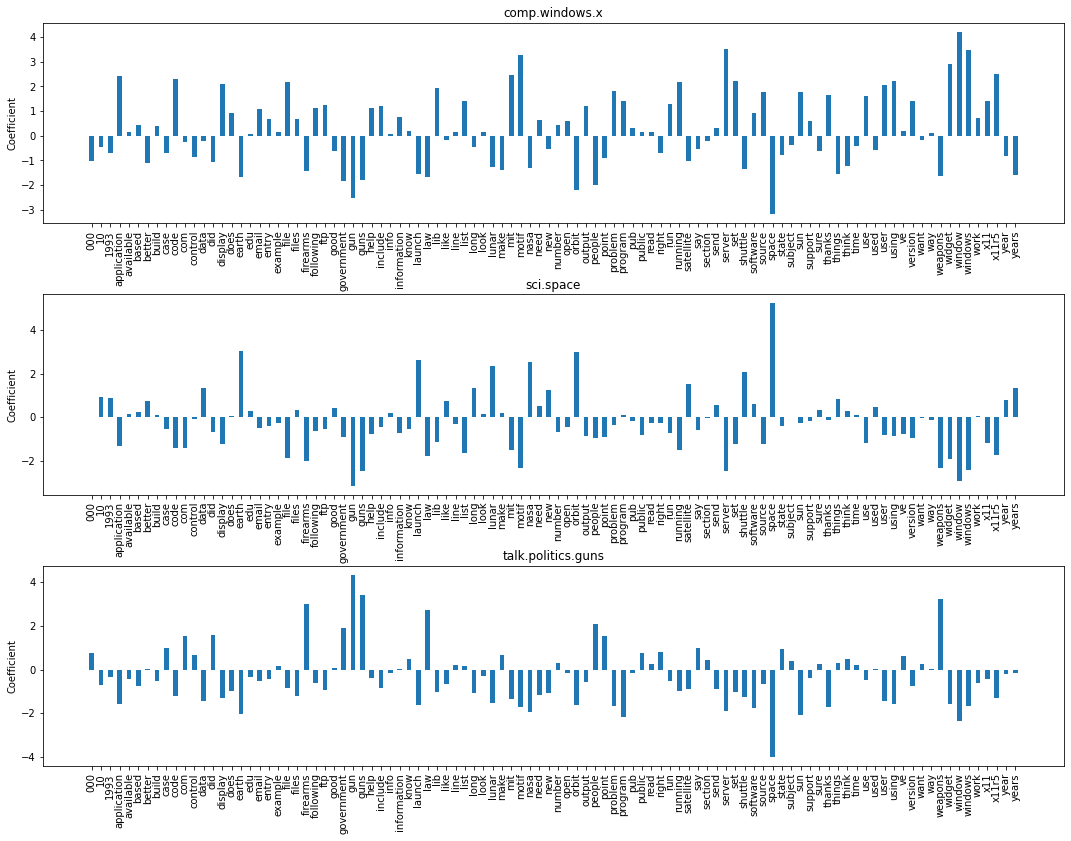

In [17]:
#Important words: space, orbit, window, windows, gun, guns
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.tight_layout(pad=5.0)

axs[0].bar(vectorizer2.get_feature_names(), lr.coef_[0], width = 0.5)
axs[0].set_ylabel("Coefficient")
axs[0].set_title("comp.windows.x")
axs[0].tick_params(axis='x', labelrotation = 90)

axs[1].bar(vectorizer2.get_feature_names(), lr.coef_[1], width = 0.5)
axs[1].set_ylabel("Coefficient")
axs[1].set_title("sci.space")
axs[1].tick_params(axis='x', labelrotation = 90)

axs[2].bar(vectorizer2.get_feature_names(), lr.coef_[2], width = 0.5)
axs[2].set_ylabel("Coefficient")
axs[2].set_title("talk.politics.guns")
axs[2].tick_params(axis='x', labelrotation = 90)
plt.show()

## 4.2 Linear Model

Try to improve your baseline by trying several (2-3) different linear classifiers, making sure to carefully tune hyperparameters and use cross-validation.

What words/terms does your best model think are most important? Try to interpret your model.

Optional: You are welcome to add extra features you think might be useful. That might be the count of a particular word in each post (e.g., a popular misspelling of a word), whether or not a particular email address is mentioned, etc. There is not a ton of room for customization here, but there are some things to try.

In [18]:
lr2 = LogisticRegression(penalty='l2')

param_grid = {'C': np.logspace(-3, 3, 20), 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
grid = GridSearchCV(lr2, param_grid, cv=5, n_jobs=-1)
grid.fit(X2, df['Category Label'])
print("Grid best model score: " + str(grid.best_params_) + " " + str(grid.best_score_.round(3)))

lr2 = LogisticRegression(penalty='l2', solver='saga', C=0.1623776739188721)
print("Score: " + str(np.mean(cross_val_score(lr2, X2, df['Category Label'], cv=5)).round(3)))
lr2.fit( X2, df['Category Label']);

Grid best model score: {'C': 0.1623776739188721, 'solver': 'saga'} 0.822
Score: 0.822


D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


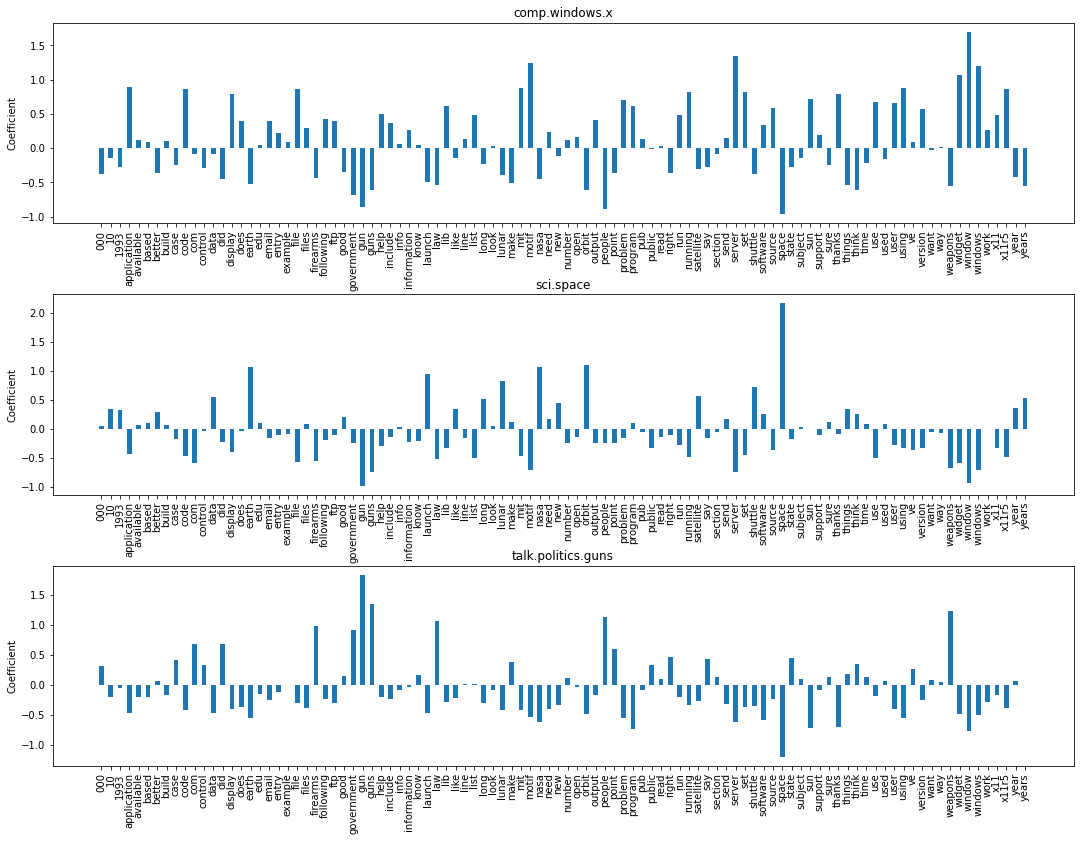

In [19]:
#Important words: space, orbit, window, server, gun, firearms
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(16, 12)
fig.tight_layout(pad=5.0)

axs[0].bar(vectorizer2.get_feature_names(), lr2.coef_[0], width = 0.5)
axs[0].set_ylabel("Coefficient")
axs[0].set_title("comp.windows.x")
axs[0].tick_params(axis='x', labelrotation = 90)

axs[1].bar(vectorizer2.get_feature_names(), lr2.coef_[1], width = 0.5)
axs[1].set_ylabel("Coefficient")
axs[1].set_title("sci.space")
axs[1].tick_params(axis='x', labelrotation = 90)

axs[2].bar(vectorizer2.get_feature_names(), lr2.coef_[2], width = 0.5)
axs[2].set_ylabel("Coefficient")
axs[2].set_title("talk.politics.guns")
axs[2].tick_params(axis='x', labelrotation = 90)
plt.show()

## 4.3 Non-Linear Model

Now do the same as above but use non-linear models. Try out 2-3 of them.

In [20]:
tree = DecisionTreeRegressor(max_depth= None, max_features='auto', splitter='random').fit(X2, df['Category Label'])

print("Score: " + str(np.mean(cross_val_score(tree, X2, df['Category Label'], cv=5)).round(3)))
tree.fit(X2, df['Category Label']);

Score: 0.492


D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


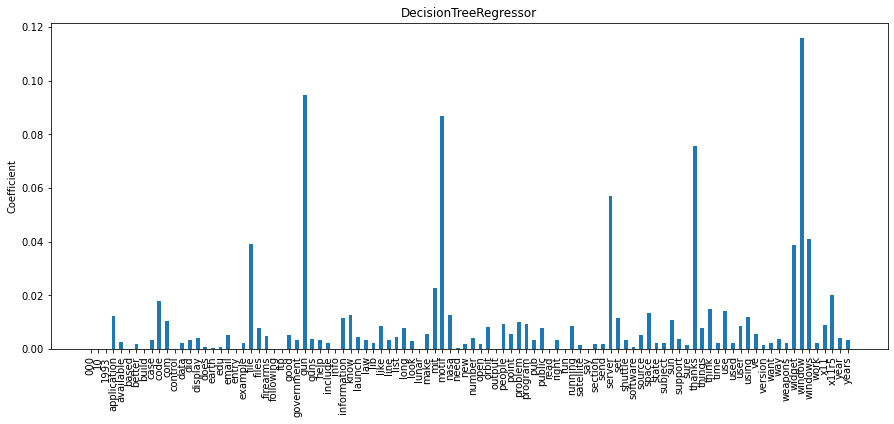

In [21]:
#Important words: Window, server, widget, file, motif
plt.figure(figsize=(15, 6))
plt.bar(vectorizer2.get_feature_names(), tree.feature_importances_, width = 0.5)
plt.ylabel("Coefficient")
plt.title("DecisionTreeRegressor")
plt.xticks(rotation = 90)
plt.show()

In [22]:
tree2 = RandomForestRegressor(max_depth=None, max_features='log2', n_estimators=250)

print("Score: " + str(np.mean(cross_val_score(tree2, X2, df['Category Label'], cv=5)).round(3)))
tree2.fit(X2, df['Category Label']);

Score: 0.688


D:\Software\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


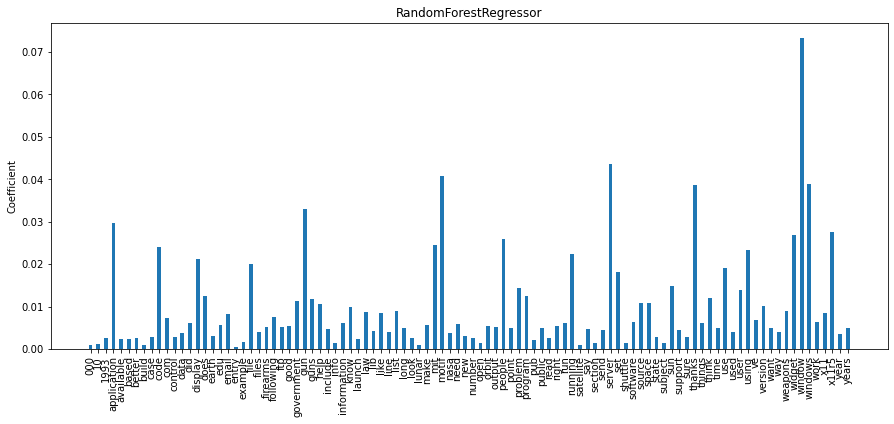

In [23]:
#Important words: Window, server, motif, thanks, windows
plt.figure(figsize=(15, 6))
plt.bar(vectorizer2.get_feature_names(), tree2.feature_importances_, width = 0.5)
plt.ylabel("Coefficient")
plt.title("RandomForestRegressor")
plt.xticks(rotation = 90)
plt.show()